**Import Libraries & Read Data**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pk
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

2025-08-25 09:58:13.346778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756115893.537991      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756115893.595274      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",names=["ID","Company","Sentiment","Text"])
train.head()

,ID,Company,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
val = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",names=["ID","Company","Sentiment","Text"])
val.head()

,ID,Company,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


**Data Exploration**

In [4]:
#Shape Of Data
train.shape

(74682, 4)

In [5]:
val.shape

(1000, 4)

In [6]:
#Info Of Data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Company    74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Company    1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
#NULL Data
train.isna().sum()

ID             0
Company        0
Sentiment      0
Text         686
dtype: int64

In [9]:
val.isna().sum()

ID           0
Company      0
Sentiment    0
Text         0
dtype: int64

In [10]:
train.dropna(inplace=True)

In [11]:
train.isna().sum()

ID           0
Company      0
Sentiment    0
Text         0
dtype: int64

In [12]:
train.describe(include='object').transpose()

,count,unique,top,freq
Company,73996,32,LeagueOfLegends,2377
Sentiment,73996,4,Negative,22358
Text,73996,69491,"At the same time, despite the fact that there ...",172


In [13]:
train.Sentiment.value_counts()

Sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

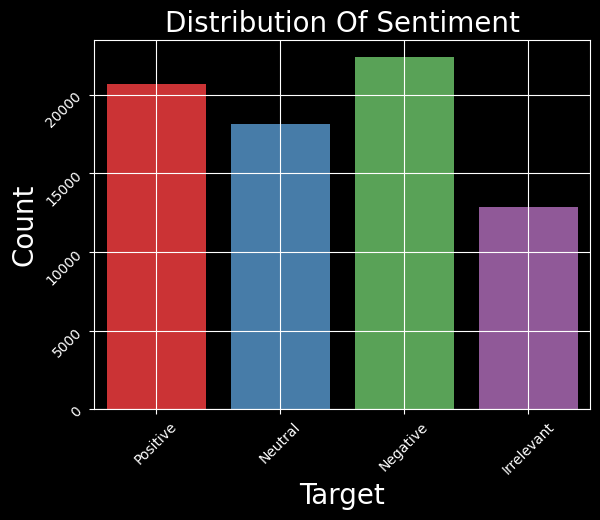

In [14]:
plt.style.use("dark_background")
sns.countplot(x='Sentiment',data=train,palette='Set1')
plt.title('Distribution Of Sentiment',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

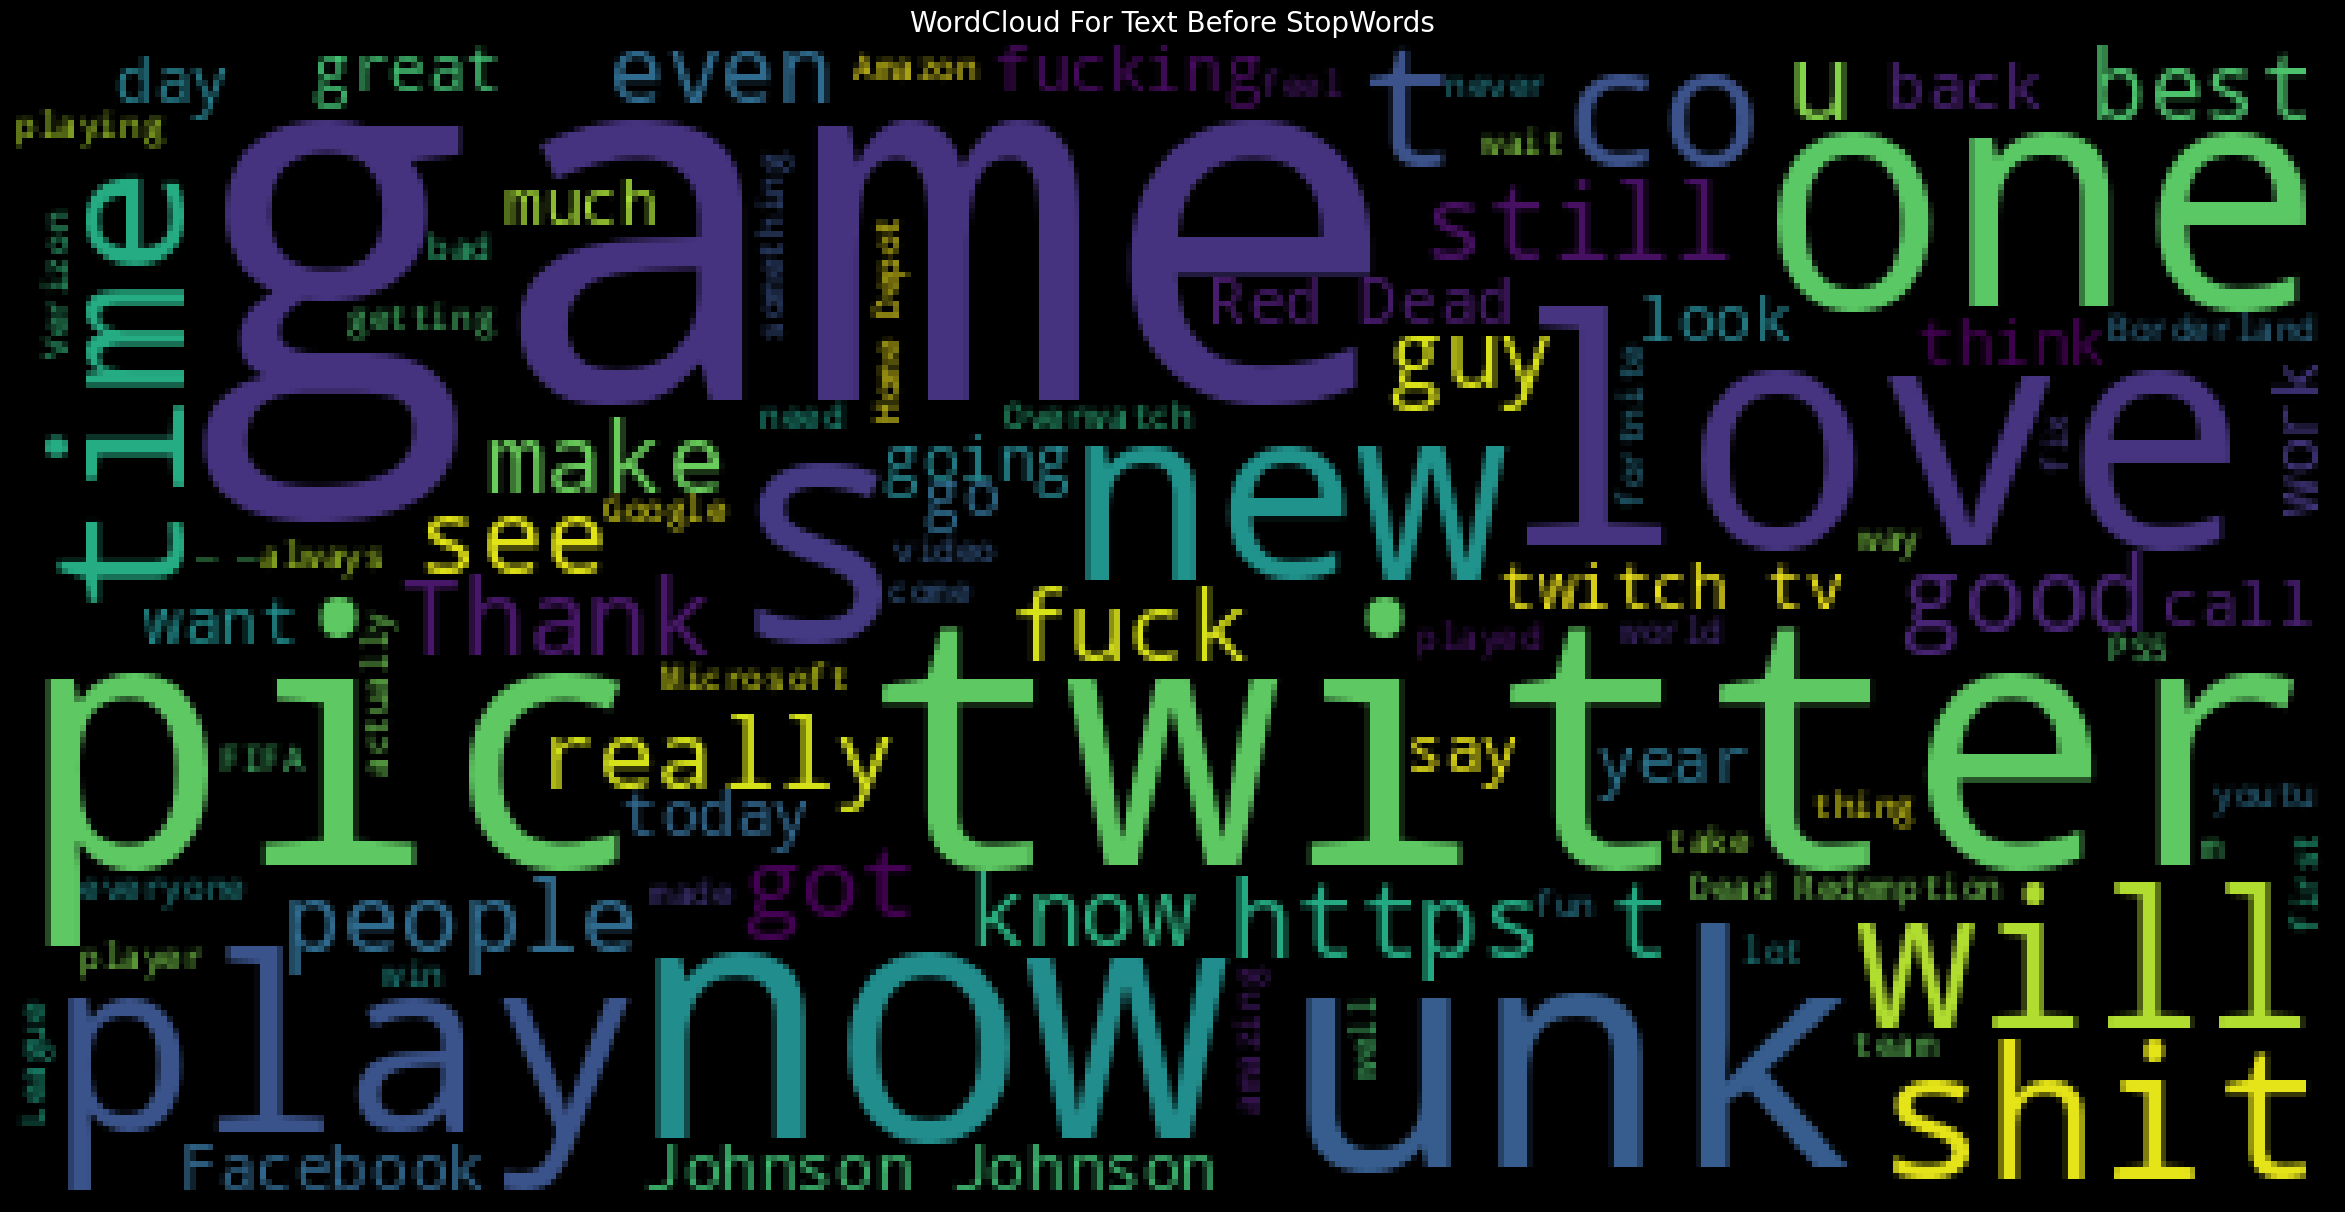

In [15]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud(background_color = 'black').generate(" ".join(train.Text)))
plt.axis("off")
plt.title("WordCloud For Text Before StopWords",fontsize=20)
plt.show()   

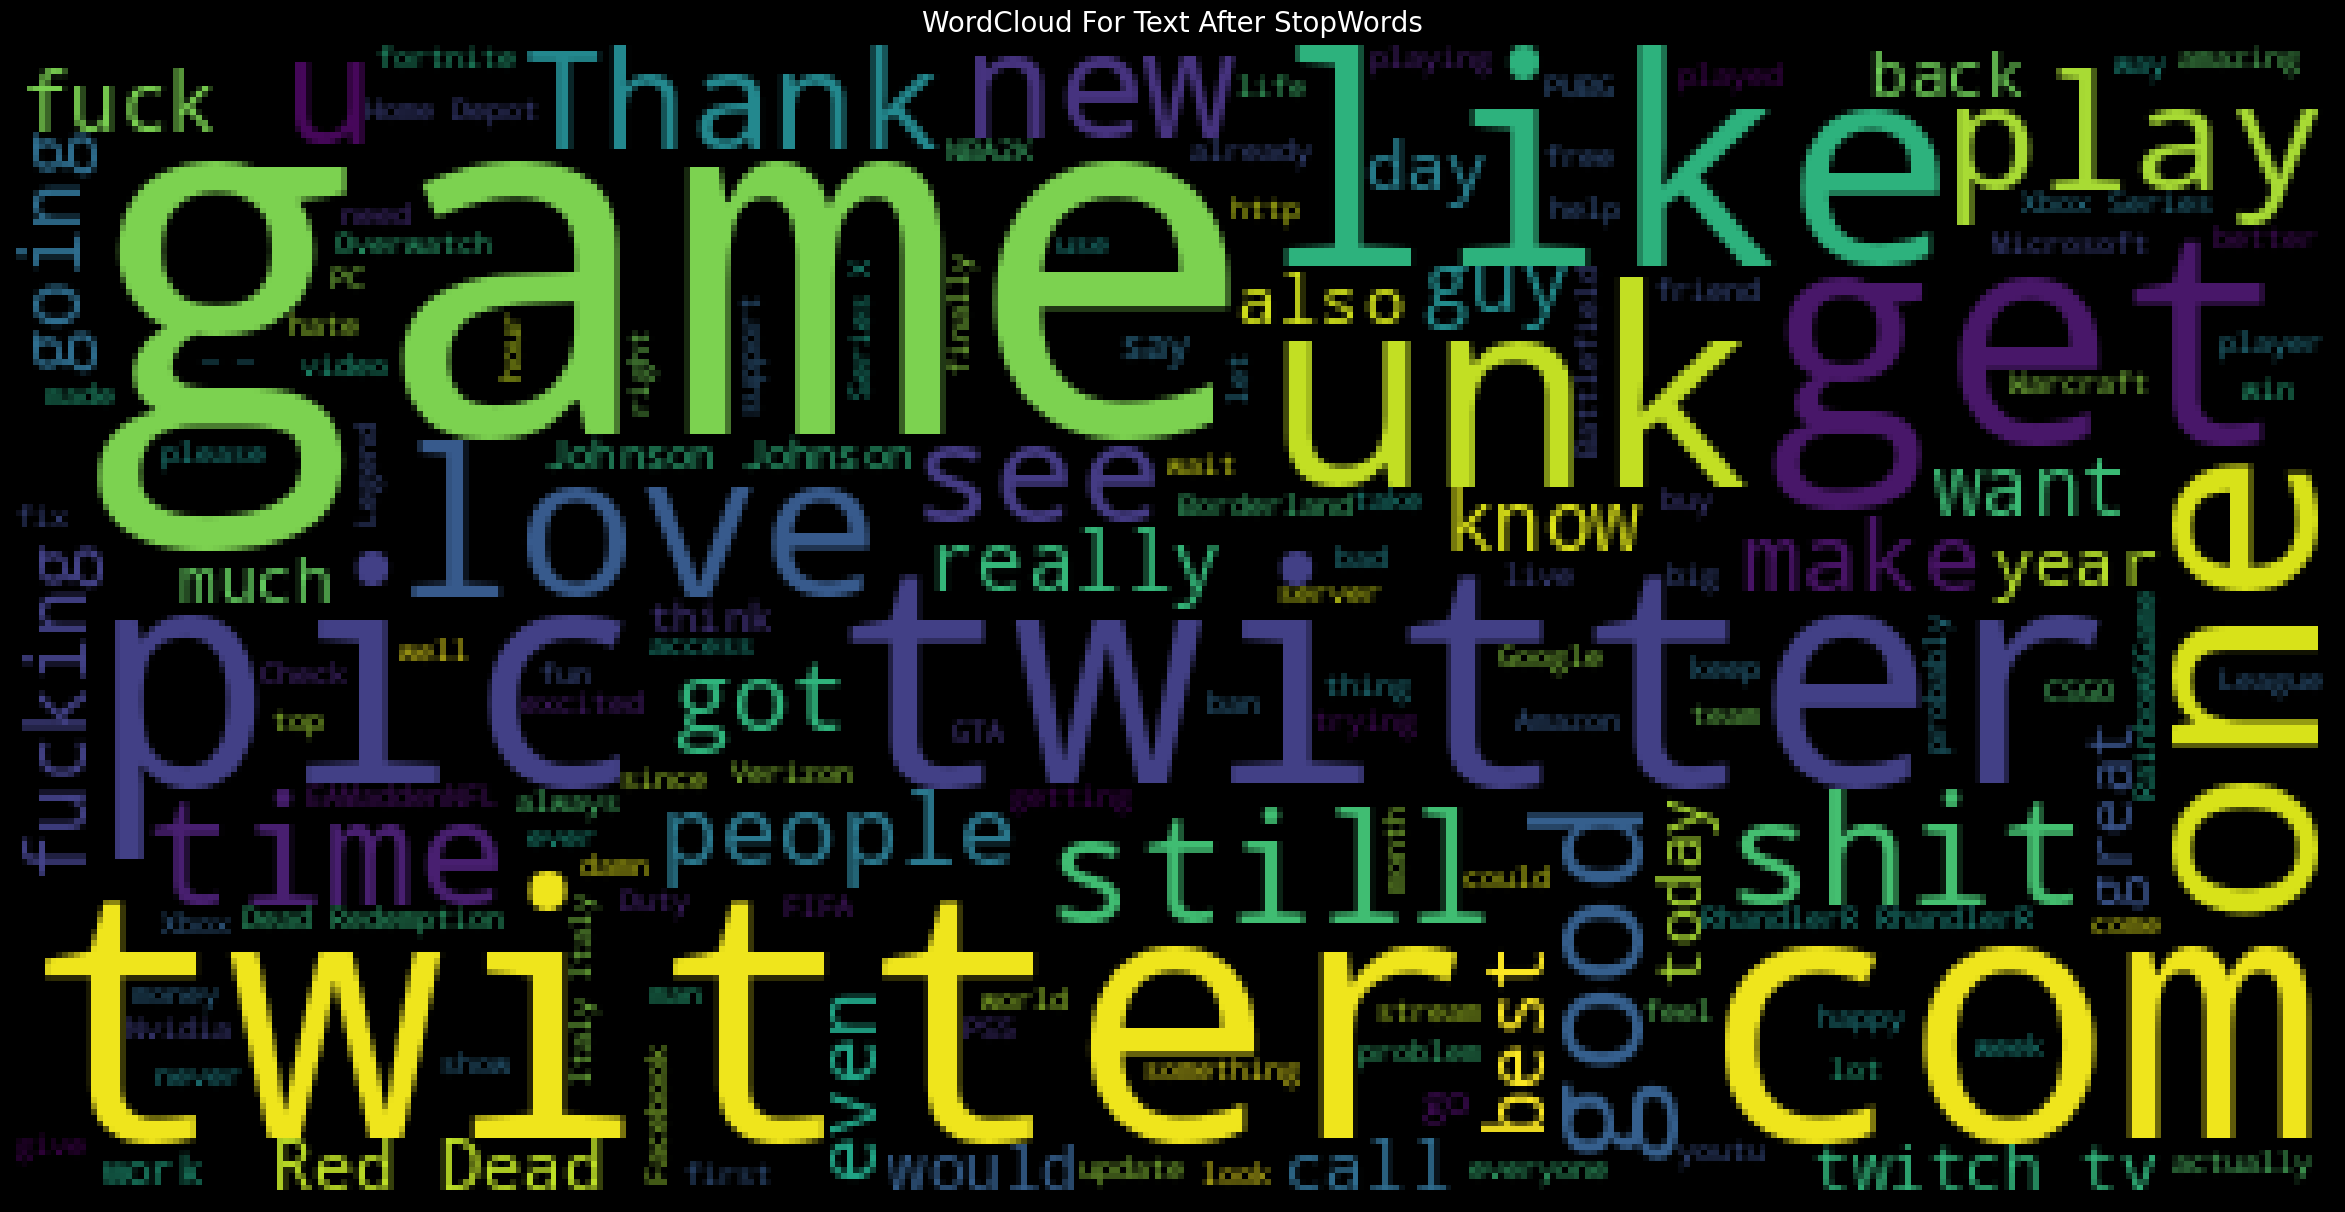

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud(background_color = 'black',stopwords=set(stopwords.words('english'))).generate(" ".join(train.Text)))
plt.axis("off")
plt.title("WordCloud For Text After StopWords",fontsize=20)
plt.show()  

**Model Building**

In [17]:
#Input
Text = train.Text
val_Text = val.Text
Text

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: Text, Length: 73996, dtype: object

In [18]:
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [19]:
Text = Text.apply(clean_text)
val_Text = val_Text.apply(clean_text)
Text

0        im getting on borderlands and i will murder yo...
1        i am coming to the borders and i will kill you...
2        im getting on borderlands and i will kill you all
3        im coming on borderlands and i will murder you...
4        im getting on borderlands and i will murder yo...
                               ...                        
74677    just realized that the windows partition of my...
74678    just realized that my mac window partition is ...
74679    just realized the windows partition of my mac ...
74680    just realized between the windows partition of...
74681    just like the windows partition of my mac is l...
Name: Text, Length: 73996, dtype: object

In [20]:
#Output
Target = train.Sentiment
val_Target = val.Sentiment
Target

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74677    Positive
74678    Positive
74679    Positive
74680    Positive
74681    Positive
Name: Sentiment, Length: 73996, dtype: object

In [21]:
#Transform Output
encoder = LabelEncoder()
Target = encoder.fit_transform(Target)
val_Target = encoder.transform(val_Target)
Target

array([3, 3, 3, ..., 3, 3, 3])

In [22]:
vectorizer = TfidfVectorizer()
Text = vectorizer.fit_transform(Text)
val_Text = vectorizer.transform(val_Text)

In [23]:
for feature in np.random.randint(0,len(vectorizer.vocabulary_.keys()),100):
    print(list(vectorizer.vocabulary_.keys())[feature],end=' & ')

congratz & vojzgy & cracks & tshirts & meni & wandercup & dwvoqycse & beth & towers & digitized & edhernandezw & fournier & aspire & bueno & assins & empathy & sry & saints & elounk & fever & skipped & poscauk & mw & likebeoztxaxm & bulls & ronk & aperture & unkve & yesm & nos & defying & interactionsocial & culturalwar & donalds & mypf & nighthylifede & pederasts & diseaseresistant & plusunk & onedon & hjupwu & cnfrdddui & godlike & buffoon & nword & computerworldcom & chbxpyrf & jolie & xnmezwzt & confidential & pair & panelists & httpstcoxvmorlgi & moronic & actuallyve & pileunk & pictwittercomrvwsrkdng & ccbeajuvoszk & saddened & initiation & almighty & mapppppppppppp & duplicating & jump & pictwittercomeocyqjzobo & mixercomxyzvnru & pictwittercomvwaflay & crossgenerational & flashback & heartstonesd & pathy & bgt & qqxkj & untested & municipal & moralde & valvesofix & timecomgho & firstplay & launcher & naxxramas & arb & gingehcs & rainforest & braindead & supplemented & amzntoomv

In [24]:
#Model
model=Pipeline([
    #('tfid',TfidfVectorizer()),
    ('model',RandomForestClassifier(criterion = 'gini',n_estimators=400,max_depth=600,random_state=44))
    ])
model.fit(Text,Target)

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=600, n_estimators=400,
                                        random_state=44))])

**Model Check**

In [25]:
print('Pipeline Model Train Score is : ' , model.score(Text, Target))
print('Pipeline Model Test Score is : ' , model.score(val_Text, val_Target))

Pipeline Model Train Score is :  0.9760392453646143
Pipeline Model Test Score is :  0.974


In [26]:
y_pred = model.predict(val_Text)
y_pred[:10]

array([0, 2, 1, 1, 2, 1, 3, 3, 3, 1])

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


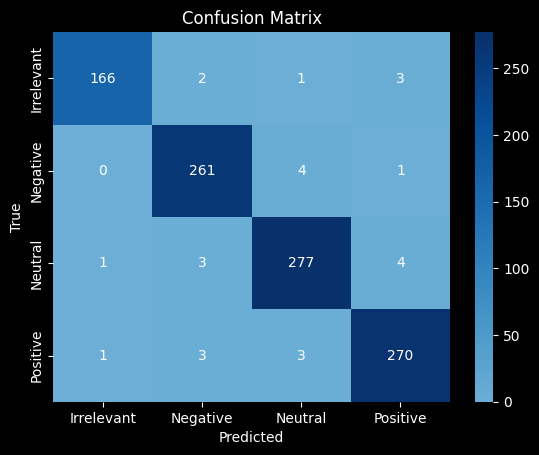

array([[166,   2,   1,   3],
       [  0, 261,   4,   1],
       [  1,   3, 277,   4],
       [  1,   3,   3, 270]])

In [27]:
class_name = train['Sentiment'].unique()[::-1]
CM = confusion_matrix(val_Target, y_pred)
sns.heatmap(CM,annot=True,fmt='g',center = True,cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
CM

In [28]:
ClassificationReport = classification_report(val_Target,y_pred,target_names=class_name)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

  Irrelevant       0.99      0.97      0.98       172
    Negative       0.97      0.98      0.98       266
     Neutral       0.97      0.97      0.97       285
    Positive       0.97      0.97      0.97       277

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



**Keras Model**

In [29]:
max_words = 20000  
max_len = 200      
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.Text)

In [30]:
X_train_seq = tokenizer.texts_to_sequences(train.Text)
X_val_seq = tokenizer.texts_to_sequences(val.Text)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

In [31]:
y_train_cat = to_categorical(Target, num_classes=4)
y_val_cat = to_categorical(val_Target, num_classes=4)

In [32]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1756117039.839035      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(X_train_pad, y_train_cat, 
                    validation_data=(X_val_pad,y_val_cat), 
                    epochs=20, 
                    batch_size=32, 
                    callbacks=[early_stop, checkpoint])

Epoch 1/20


I0000 00:00:1756117045.052712      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.5838 - loss: 0.9879 - val_accuracy: 0.9170 - val_loss: 0.2727
Epoch 2/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8780 - loss: 0.3320 - val_accuracy: 0.9440 - val_loss: 0.2029
Epoch 3/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9222 - loss: 0.2056 - val_accuracy: 0.9480 - val_loss: 0.2153
Epoch 4/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9399 - loss: 0.1533 - val_accuracy: 0.9500 - val_loss: 0.2145
Epoch 5/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9503 - loss: 0.1244 - val_accuracy: 0.9510 - val_loss: 0.2101
Epoch 6/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9550 - loss: 0.1093 - val_accuracy: 0.9450 - val_loss: 0.2532
Epoch 7/20
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9618 - loss: 0.0919 - val_accuracy: 0.9420 - val_loss: 0.2876


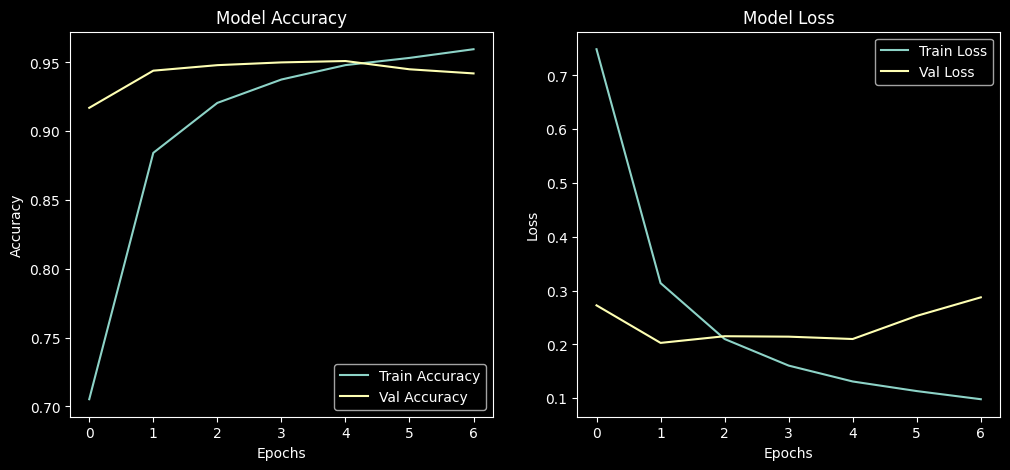

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
val_loss, val_acc = model.evaluate(X_val_pad,y_val_cat)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9421 - loss: 0.2133
Validation Accuracy: 0.9440
Validation Loss: 0.2029


In [36]:
pred_probs = model.predict(X_val_pad)
y_pred = np.argmax(pred_probs, axis=1)
y_pred[:10]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([0, 2, 1, 1, 2, 1, 3, 0, 3, 1])

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


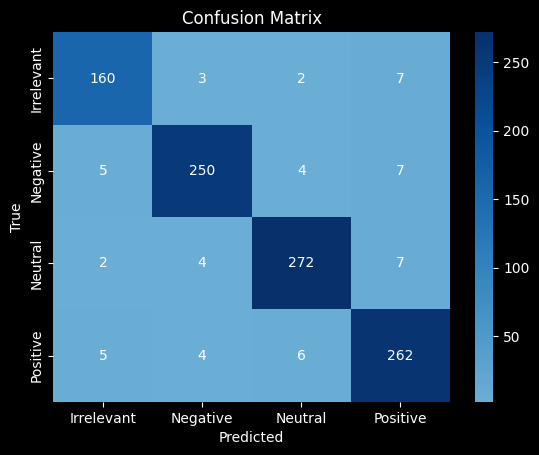

array([[160,   3,   2,   7],
       [  5, 250,   4,   7],
       [  2,   4, 272,   7],
       [  5,   4,   6, 262]])

In [37]:
CM = confusion_matrix(val_Target, y_pred)
sns.heatmap(CM,annot=True,fmt='g',center = True,cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
CM

In [38]:
ClassificationReport = classification_report(val_Target,y_pred,target_names=class_name)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

  Irrelevant       0.93      0.93      0.93       172
    Negative       0.96      0.94      0.95       266
     Neutral       0.96      0.95      0.96       285
    Positive       0.93      0.95      0.94       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

